<a href="https://colab.research.google.com/github/EmersonFranca/IDH_Atlas/blob/master/Funcoes/Funcoes_para_Previsao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importando Bibliotecas

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import probplot

# 2. Versões das bibliotecas importadas

In [78]:
print(pd.__version__)
print(np.__version__)
print(sns.__version__)


1.0.3
1.18.4
0.10.1


# 3. Importando os dados

In [0]:
URL_IDH_1991 = "https://github.com/EmersonFranca/IDH_Atlas/blob/master/Dados/IDH_1991.csv?raw=true"
URL_IDH_2000 = "https://github.com/EmersonFranca/IDH_Atlas/blob/master/Dados/IDH_2000.csv?raw=true"
URL_IDH_2010 = "https://github.com/EmersonFranca/IDH_Atlas/blob/master/Dados/IDH_2010.csv?raw=true"

In [0]:
dfIDH_2000 = pd.read_csv(URL_IDH_2000,sep=';')

# 4. Preparando os dados para testar as minhas funções

In [81]:
colunas_analise = ['RDPC','T_AGUA','AGUA_ESGOTO','T_LIXO','T_LUZ','T_BANAGUA']

list

In [82]:
df = dfIDH_2000[colunas_analise]
df.head()

,RDPC,T_AGUA,AGUA_ESGOTO,T_LIXO,T_LUZ,T_BANAGUA
0,371.15,57.13,27.52,70.33,70.14,42.56
1,530.87,73.54,21.14,90.61,93.43,67.08
2,342.46,58.61,27.36,76.57,80.31,46.33
3,456.63,78.60,14.28,90.22,90.58,67.20
4,511.47,73.98,24.82,70.04,91.79,61.93


### <font color = 'green'> Definindo  minha variável dependente </font>

###### RDPC -> Renda per Capita do Município

In [0]:
df_y = df['RDPC']

### <font color = 'green'> Definindo  minhas variáveis explicativas </font>

In [84]:
df_X = df[['T_AGUA','AGUA_ESGOTO','T_LIXO','T_LUZ','T_BANAGUA']]
df_X.head()

,T_AGUA,AGUA_ESGOTO,T_LIXO,T_LUZ,T_BANAGUA
0,57.13,27.52,70.33,70.14,42.56
1,73.54,21.14,90.61,93.43,67.08
2,58.61,27.36,76.57,80.31,46.33
3,78.60,14.28,90.22,90.58,67.20
4,73.98,24.82,70.04,91.79,61.93


### <font color = 'green'> Separando 30% dos dados para teste e 70% para treino </font>

In [100]:
def retorna_dfTeste_e_dfTreino(parame_df, param_percentual_em_decimal_para_teste, param_random_state, paramm_nome_variavel_y):

  #Definindo a quantidade de registros para teste, com base no % de registros do DataFrame e a quantidade total de registros do DataFrame. O % é definido pelo param_percentual_em_decimal_para_teste. EXEMPLO= se passar o param_percentual_em_decimal_para_teste como 0.3, vai ser pego 30% de linhas do dataframe
  qt_para_teste = round(len(parame_df) * param_percentual_em_decimal_para_teste)
  
  #Seleciona uma quantidade de registros = qt_para_teste, de forma aleatória
  fun_df_teste = parame_df.sample(n = qt_para_teste, random_state = param_random_state)

  # deep = True indica que os dataFrames fun_df_treino e parame_df, são independentes, qualquer alteração em um deles, NÃO vai refletir no outro
  fun_df_treino = parame_df.copy(deep = True) 

  # Gravo na series, com o índice(que será utilizado para comparar com o dataframe geral)
  seriesRDPC_teste = fun_df_teste[paramm_nome_variavel_y]

  # Estou gravando numa coluna nova, indicando se o registro está no Dataframe de Teste(=True) ou não(=False). O método "isin" compara pelo índice do dataframe passado por parâmetro, com a series "seriesRDPC_teste", retorna True, caso o índice da linha do dataframe seja igual a pelo menos um dos índices da seriesRDPC_teste
  fun_df_treino['Registro_de_Teste'] = parame_df.isin(seriesRDPC_teste)[paramm_nome_variavel_y].copy()

  # Selecionando apenas os registros que não são de treino
  fun_df_treino.query('Registro_de_Teste == False', inplace = True)

  # Exclui a coluna Registro_de_Teste
  fun_df_treino.drop(labels='Registro_de_Teste', axis='columns', inplace=True)

  return fun_df_teste,fun_df_treino

teste,treino = retorna_dfTeste_e_dfTreino(df,0.3,123,'RDPC')  
print("Quantidade de registros para Teste: ",len(teste))
print("Quantidade de registros para Treino: ",len(treino))

Quantidade de registros para Teste:  1670
Quantidade de registros para Treino:  3895


In [86]:
def retorna_Colunas_Explicativas(paramm_df, paramm_nome_variavel_y):
  _ = paramm_df.columns.to_frame(index=False, name = 'Coluna')
  _ = _.query("Coluna != '" + paramm_nome_variavel_y + "'")
  _ = _["Coluna"]

  return _
 
retorna_Colunas_Explicativas(df,'RDPC')

1         T_AGUA
2    AGUA_ESGOTO
3         T_LIXO
4          T_LUZ
5      T_BANAGUA
Name: Coluna, dtype: object

In [87]:
def retorna_y(param_df,param_nome_variavel_y):
  _ = param_df[[param_nome_variavel_y]]
  return _  

retorna_y(df,'RDPC').head(1)  

,RDPC
0,371.15


In [88]:
def retorna_X(paramm_df, paramm_nome_variavel_y):
  _ = retorna_Colunas_Explicativas(paramm_df,paramm_nome_variavel_y)

  return paramm_df[_]   

retorna_X(df,'RDPC').head(1)

,T_AGUA,AGUA_ESGOTO,T_LIXO,T_LUZ,T_BANAGUA
0,57.13,27.52,70.33,70.14,42.56


In [118]:
def testa_modelo(parametro_modelo,parametro_df_teste, parametro_df_treino):

  df_X_teste = retorna_X(parametro_df_teste,'RDPC')
  df_y_teste = retorna_y(parametro_df_teste,'RDPC')

  df_X_treino = retorna_X(parametro_df_treino, 'RDPC')
  df_y_treino = retorna_y(parametro_df_treino, 'RDPC')

  # Preenche o modelo com os dados de treino
  parametro_modelo.fit(df_X_treino,df_y_treino)


  # Aqui eu faço a predição com os dados de teste, retornando o y previsto
  retorno_y_previsto_teste = parametro_modelo.predict(df_X_teste)

  # Aqui retorno o erro quadratico medio comparando o y de teste com o y previsto
  retorno_raiz_do_erro_quadratico_medio = np.sqrt(  mean_squared_error(df_y_teste, retorno_y_previsto_teste)  )

  # Retornando o R² comparando o y de teste com o y previsto
  retorno_r2_Score = metrics.r2_score(df_y_teste, retorno_y_previsto_teste)

  # deep = True indica que os retorno_df_teste e parametro_df_teste, são independentes, qualquer alteração em um deles, NÃO vai refletir no outro
  retorno_df_teste = parametro_df_teste.copy(deep=True)

  # Criando variáveis que me ajudarão na análise do modelo preditivo
  retorno_df_teste['y_previsto'] = retorno_y_previsto_teste
  retorno_df_teste['Residuo'] = retorno_df_teste['RDPC'] - retorno_df_teste['y_previsto']
  retorno_df_teste['Residuo_Absoluto'] = np.sqrt(retorno_df_teste['Residuo'] ** 2)

  #
  ax = List()
  plota_geral(retorno_df_teste)


  # Aqui retorno tudo
  return retorno_df_teste, retorno_r2_Score ,retorno_raiz_do_erro_quadratico_medio 

#--------------------------------------------------
#----------------------***FIM***-------------------
#--------------------------------------------------

modelo = xgboost.XGBRegressor(learning_rate=0.1,max_depth=3,n_estimators=100,reg_alpha=0.80,seed=180) 

df_2teste, df_2treino = retorna_dfTeste_e_dfTreino(df,0.3,123,'RDPC')

df_teste_retorno, r2_Score ,raiz_do_erro_quadratico_medio = testa_modelo(modelo,df_2teste,df_2treino)

print ("df_teste_retorno: ", df_teste_retorno.shape)
print ("r2_score: ", r2_Score)
print("raiz_do_erro_quadratico_medio: ", raiz_do_erro_quadratico_medio)

[19:16:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
df_teste_retorno:  (1670, 9)
r2_score:  0.6615025330789903
raiz_do_erro_quadratico_medio:  114.70502325202254


In [0]:
def plota_probplot_residuos(param_probplot_df):

  (_, (_, _, _)) = probplot(df_teste_retorno.Residuo, plot = plt)
  return (_, (_, _, _))

In [0]:
def plota_residuos_vs_yprevisto(param_plot_df):

  ax = sns.scatterplot(x=param_plot_df.y_previsto, y=param_plot_df.Residuo)
  ax.figure.set_size_inches(12,6)
  ax.set_title('Resíduos vs Variável Independente (y)', fontsize=18)
  return ax

In [0]:
def plota_regressaolinear_RDPC_yprevisto(param_regressaolinear_plot_df):

  ax = sns.lmplot(data=param_regressaolinear_plot_df,x='RDPC', y='Residuo', palette='Set2')
  ax.fig.set_size_inches(12, 6)
  ax.fig.suptitle('Reta de Regressão', fontsize=16, y=1.02)
  return ax

In [0]:
def plota_geral(param_plotgeral_df):

  lista_graficos = list()

  lista_graficos.append(  plota_residuos_vs_yprevisto(param_plotgeral_df)  )
  lista_graficos.append(  plota_regressaolinear_RDPC_yprevisto(param_plotgeral_df) )

  

  return lista_graficos

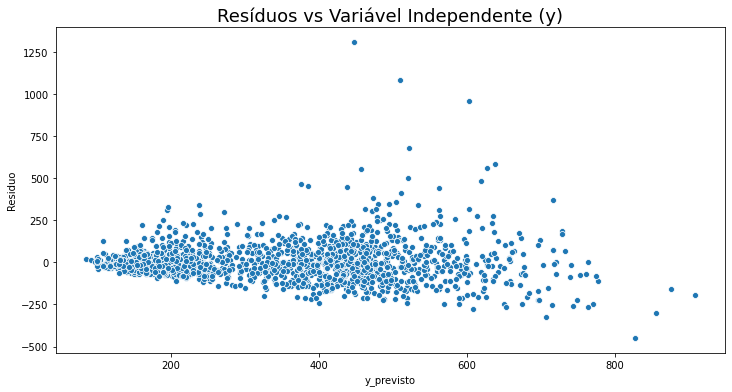

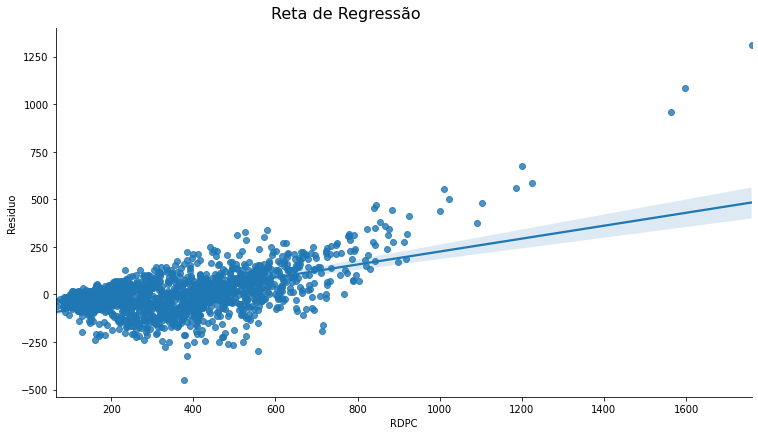

In [155]:
testandoplot = plota_geral(df_teste_retorno)
testandoplot

In [103]:
df_2treino.head()

,RDPC,T_AGUA,AGUA_ESGOTO,T_LIXO,T_LUZ,T_BANAGUA
0,371.15,57.13,27.52,70.33,70.14,42.56
1,530.87,73.54,21.14,90.61,93.43,67.08
2,342.46,58.61,27.36,76.57,80.31,46.33
3,456.63,78.60,14.28,90.22,90.58,67.20
5,401.32,70.51,24.24,58.71,92.39,57.73
